# Estimate Penetration From Bologna Data

In [ ]:
from collections import defaultdict
from datetime import datetime
import json
import os
import polars as pl
import pandas as pd
import geopandas as gpd
from GeographyFunctions import FilterGeoDataFrameWithBoundingBox
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import numpy as np
from EstimatePenetration import *
from OpenData import *
from SubNetworks import *


# Input Variables

In [ ]:
## ------------ SHARED VARIABLES ----------------- ##
# Important Folders
city_pro_dir = os.path.join(os.environ["WORKSPACE"],"city-pro") 
vars_dir = os.path.join(city_pro_dir, "vars")
# Config
dir_config_analysis_day = os.path.join(vars_dir,"config","config_days_bbox.json")
# N classes 
with open(os.path.join(dir_config_analysis_day),"r") as f:
    config_analysis_day = json.load(f)

# Name project-bbox
prefix_files = "bologna_mdt"
name_project_related_to_bbox = config_analysis_day["name_project"]


# Folders
config_dir = os.path.join(city_pro_dir,name_project_related_to_bbox)
fcm_dir = os.path.join(os.environ["WORKSPACE"],"city-pro","output",name_project_related_to_bbox)
PlotDir = os.path.join(fcm_dir, "plots")



# Parameters Days - Classes
StrDates = config_analysis_day["str_dates"]
num_tm = config_analysis_day["num_tm"]
labels = [str(i) for i in range(num_tm)]
Classes = [int(i) for i in range(num_tm)]

# Variables of Interest
Features = ["time_hours", "lenght_km"]

# 
lon_min,lon_max,lat_min,lat_max = config_analysis_day["lon_min"], config_analysis_day["lon_max"], config_analysis_day["lat_min"], config_analysis_day["lat_max"]


2022-01-31
shape: (5, 4)
┌──────────────┬──────────┬─────────────┬───────────────────┐
│ total_fluxes ┆ id_local ┆ 00:00-01:00 ┆ penetration_total │
│ ---          ┆ ---      ┆ ---         ┆ ---               │
│ i64          ┆ i64      ┆ i64         ┆ f64               │
╞══════════════╪══════════╪═════════════╪═══════════════════╡
│ 6            ┆ 505      ┆ 75          ┆ 0.08              │
│ 6            ┆ 505      ┆ 59          ┆ 0.101695          │
│ 6            ┆ 505      ┆ 45          ┆ 0.133333          │
│ 6            ┆ 505      ┆ 74          ┆ 0.081081          │
│ 6            ┆ 505      ┆ 26          ┆ 0.230769          │
└──────────────┴──────────┴─────────────┴───────────────────┘
shape: (5, 4)
┌──────────────┬──────────┬─────────────┬───────────────────┐
│ total_fluxes ┆ id_local ┆ 01:00-02:00 ┆ penetration_total │
│ ---          ┆ ---      ┆ ---         ┆ ---               │
│ i64          ┆ i64      ┆ i64         ┆ f64               │
╞══════════════╪══════════╪════

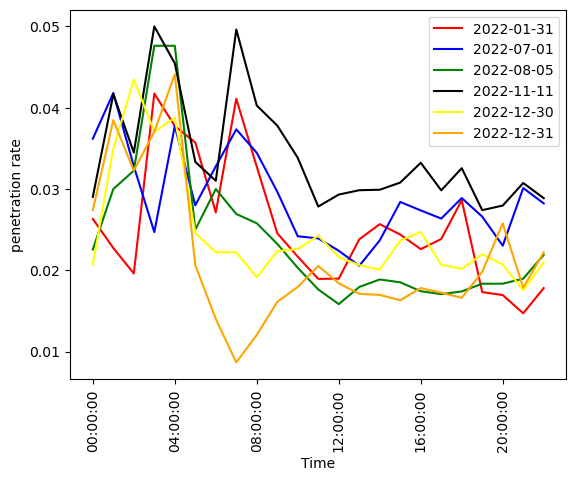

In [ ]:
# Names Project
name_folder_related_to_bbox = "bologna_mdt_center"

# Directories: Dependent on the bbox
plot_dir = os.path.join(os.environ["WORKSPACE"],f"city-pro","output",name_folder_related_to_bbox,"plots")
DirOpenDataBologna = os.path.join(os.environ["WORKSPACE"],"city-pro","bologna_mdt_detailed","carto")                            # NOTE: 


# Days - Days related variables
Days = ["2022-01-31","2022-07-01","2022-08-05","2022-11-11","2022-12-30","2022-12-31","2023-01-01","2023-03-18"] 



FilePro = os.path.join(DirOpenDataBologna, "bologna_mdt_cleaned.pro")

# Open Data
GdfTrafficOpenData2022,Column2ConsiderGdfTrafficOpenData,TimeRanges = OpenDataFrameSpireAndTransformGeoData(DirOpenDataBologna,Days,StrFile = "rilevazione-flusso-veicoli-tramite-spire-anno-2022.csv")
# GdfTrafficOpenData2023,_,_ = OpenDataFrameSpireAndTransformGeoData(DirOpenDataBologna,Days,StrFile = "accuratezza-spire-anno-2023.csv")
output_dir = os.path.join(os.environ["WORKSPACE"],"city-pro","output")
Day = "2022-01-31"
GdfRoads = gpd.read_file(os.path.join(output_dir,f"{name_folder_related_to_bbox}/plots/{Day}/GeoJson_{Day}.geojson"))
GdfRoads.set_crs(epsg=4326, inplace=True)
Bbox = (lon_min, lon_max, lat_min, lat_max)
GdfRoads = FilterGeoDataFrameWithBoundingBox(GdfRoads,Bbox)
fig,ax = plt.subplots()
Colors = ["red","blue","green","black","yellow","orange","purple","pink"]
Day2Color = dict(zip(Days,Colors))

for Day in Days:
    print(Day)
    TimeRange2Time = GetTimeRanges(TimeRanges,Day)
    TimedFluxes = pl.read_csv(os.path.join(os.environ["WORKSPACE"],"city-pro","output",name_folder_related_to_bbox,f"bologna_mdt_{Day}_{Day}_timed_fluxes.csv"),separator=';')
    # Ensure both GeoDataFrames use the same CRS
    # Perform a spatial join to associate points with the nearest roads
    if "2023" in Day:
        break
    else:
        GdfTrafficOpenData = GdfTrafficOpenData2022.to_crs(epsg=3857)
    GdfRoads = GdfRoads.to_crs(epsg=3857)    
    GdfJoin = gpd.sjoin_nearest(GdfTrafficOpenData, GdfRoads, how='left', distance_col='distance')
    GdfJoin = GdfJoin.loc[GdfJoin["distance"]<2]
    GdfJoin.set_crs(epsg=4326, inplace=True,allow_override=True)
    GdfJoin = DiscardColumnsSpeedGdfRoads(GdfJoin)
    PolyLid2VectorFluxes = {"average_penetration_tot": [], "average_penetration_FT": [], "average_penetration_TF": []}
    TimeHours = [Time.split(" ")[1] for Time in TimeRange2Time.values()]
    for TimeRange in TimeRange2Time.keys():
        Time = TimeRange2Time[TimeRange]
        FluxesPolysAtTime = TimedFluxes.filter(pl.col("time") == Time)
        DfJoinAtTime = pl.DataFrame(GdfJoin[[TimeRange, "poly_lid"]])
        DfJoinAtTime = DfJoinAtTime.filter(pl.col(TimeRange).is_not_null(),
                            pl.col(TimeRange).is_not_nan(),
                            pl.col(TimeRange) > 0)
        DfJoinAtTime = DfJoinAtTime.with_columns(pl.col("poly_lid").cast(pl.Int64))
        FluxesPolysAtTime = FluxesPolysAtTime.with_columns(pl.col("id").cast(pl.Int64))
        FluxesPolysAtTime = FluxesPolysAtTime.join(DfJoinAtTime,left_on="id",right_on="poly_lid")
        
        FluxesPolysAtTime = FluxesPolysAtTime.with_columns((pl.col("total_fluxes")/pl.col(TimeRange)).alias("penetration_total"),
                                                           (pl.col("n_traj_FT")/pl.col(TimeRange)).alias("penetration_FT"),
                                                           (pl.col("n_traj_TF")/pl.col(TimeRange)).alias("penetration_TF")
                                                           )
        FluxesPolysAtTime = FluxesPolysAtTime.filter(pl.col("penetration_total").is_not_null(),
                                                     pl.col("penetration_FT").is_not_null(),
                                                    pl.col("penetration_TF").is_not_null(),
                                                    pl.col("penetration_total").is_not_nan(),
                                                    pl.col("penetration_FT").is_not_nan(),
                                                    pl.col("penetration_TF").is_not_nan(),
                                                    pl.col("penetration_total") > 0,
                                                    pl.col("id")!=18952)
        PenetrationTotal = np.nanmedian(FluxesPolysAtTime["penetration_total"].to_numpy())
        PenetrationFT = np.nanmedian(FluxesPolysAtTime["penetration_FT"].to_numpy())
        PenetrationTF = np.nanmedian(FluxesPolysAtTime["penetration_TF"].to_numpy())
        PolyLid2VectorFluxes["average_penetration_tot"].append(PenetrationTotal) 
        PolyLid2VectorFluxes["average_penetration_FT"].append(PenetrationFT)
        PolyLid2VectorFluxes["average_penetration_TF"].append(PenetrationTF) 
#    ax.plot(TimeHours,PolyLid2VectorFluxes["average_penetration_tot"],label=Day,color=Day2Color[Day])
    ax.plot(TimeHours,PolyLid2VectorFluxes["average_penetration_FT"],label=Day,color=Day2Color[Day])
#    ax.plot(TimeHours,PolyLid2VectorFluxes["average_penetration_TF"],label=Day,color=Day2Color[Day])
    ax.legend()
    ax.set_xticks(range(len(TimeHours))[::4])  # Set the ticks to correspond to the labels
    ax.set_xticklabels(TimeHours[::4], rotation=90)  # Set the labels with rotation    ax.set_title("Time Percorrence Distribution")
    ax.set_xlabel("Time")
    ax.set_ylabel("penetration rate")
plt.savefig(os.path.join(os.environ["WORKSPACE"],"city-pro","output",name_folder_related_to_bbox,"penetration.png"))
plt.show()

len GdfTrafficOpenData 5051
len GdfTrafficOpenDataFilter 3936


/home/aamad/miniconda3/envs/geostuff_new/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


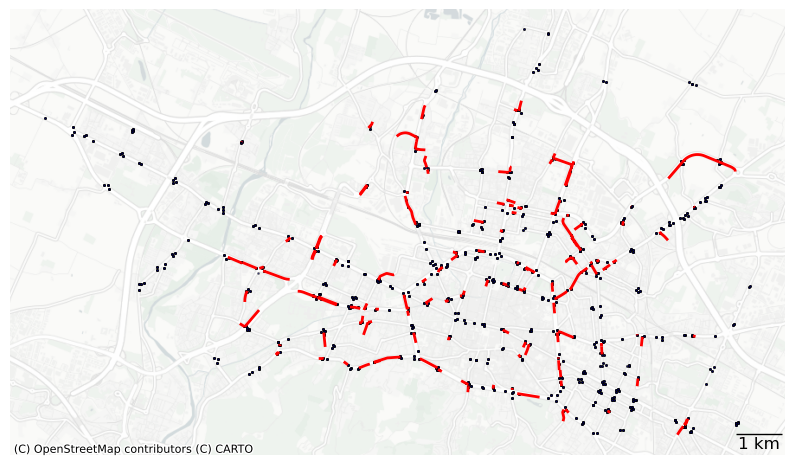

In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from shapely.geometry import box

b_box =  box(lon_min, lat_min, lon_max, lat_max)
GdfTrafficOpenData.to_crs(epsg=4326, inplace=True)
print("len GdfTrafficOpenData",len(GdfTrafficOpenData))
GdfTrafficOpenDataFilter = GdfTrafficOpenData.loc[GdfTrafficOpenData["geometry"].within(b_box)]
print("len GdfTrafficOpenDataFilter",len(GdfTrafficOpenDataFilter))
# Assuming GdfTrafficOpenData and GdfRoads are already loaded

# Filter and prepare the GdfRoads GeoDataFrame
GdfRoads["AtTimet"] = GdfRoads["poly_lid"].apply(lambda x: x in FluxesPolysAtTime["id"].to_list())
GdfRoads.to_crs(epsg=3857, inplace=True)
Columns2Accept = [col for col in GdfRoads.columns if 'Speed' not in col]
GdfRoads = GdfRoads[Columns2Accept]

# Convert GdfTrafficOpenData to EPSG:3857
GdfTrafficOpenDataFilter.to_crs(epsg=3857, inplace=True)
# Define the extent to the area of interest

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GdfTrafficOpenData as points
GdfTrafficOpenDataFilter.plot(ax=ax, alpha=0.5, edgecolor='k', marker='o', markersize=1,color='blue')

# Plot the filtered GdfRoads in red
GdfRoads.loc[GdfRoads["AtTimet"]].plot(ax=ax, color="red",linewidth=2)
ax.axis('off')
# Add a black and white basemap
ctx.add_basemap(ax, crs=GdfRoads.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)

# Set the extent to the area of interest
#ax.set_xlim(ctx.bounds2img(lon_min, lat_min, lon_max, lat_max, zoom=12)[1][0], ctx.bounds2img(lon_min, lat_min, lon_max, lat_max, zoom=12)[1][2])
#ax.set_ylim(ctx.bounds2img(lon_min, lat_min, lon_max, lat_max, zoom=12)[1][1], ctx.bounds2img(lon_min, lat_min, lon_max, lat_max, zoom=12)[1][3])

# Add a scale bar
fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(ax.transData,
                           1000, '1 km', 'lower right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
plt.savefig(os.path.join(os.environ["WORKSPACE"],f"city-pro","output",name_folder_related_to_bbox,"plots","map_coils_estimation_penetration.png"),bbox_inches='tight',dpi = 200)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# Load data
df = pd.read_csv('/home/aamad/codice/city-pro/output/bologna_mdt_center/plots/TrafficIndexAllDays.csv')

# Average over days for each time
avg_df = df.groupby('Time')[['0', '1', '2', '3']].mean().reset_index()

# Prepare time axis for plotting
times = pd.to_datetime(avg_df['Time'], format='%H:%M:%S')
times = times.dt.hour + times.dt.minute / 60  # Convert to hours
x = np.arange(len(times))

plt.figure(figsize=(12, 7))
colors = ['blue', 'yellow', 'green', 'red']
labels = ['0', '1', '2', '3']

for i, col in enumerate(['0', '1', '2', '3']):
    y = avg_df[col].values
    y_smooth = gaussian_filter1d(y, sigma=3)
    # Find peaks
    peaks, _ = find_peaks(y_smooth)
    # Take top 2 peaks by height
    if len(peaks) > 0:
        peak_heights = y_smooth[peaks]
        top_peaks_idx = np.argsort(peak_heights)[-2:]  # take 2 largest
        top_peaks = peaks[top_peaks_idx]
    else:
        top_peaks = []

    # Plot
    plt.plot(times, y_smooth, label=f'class {col}', color=colors[i])
    plt.scatter(times[top_peaks], y_smooth[top_peaks], color=colors[i], marker='o', s=100, edgecolor='k', zorder=5, label='')

plt.xlabel('Time of Day')
plt.ylabel('Average Traffic Index')
plt.title('Gaussian Filtered Traffic Curves with Peaks Highlighted')
plt.legend()
plt.tight_layout()
plt.show()

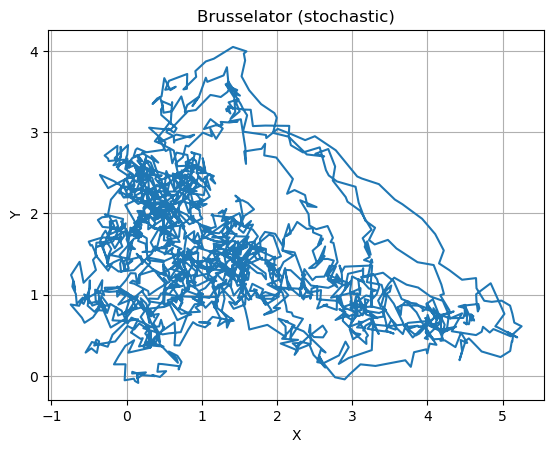

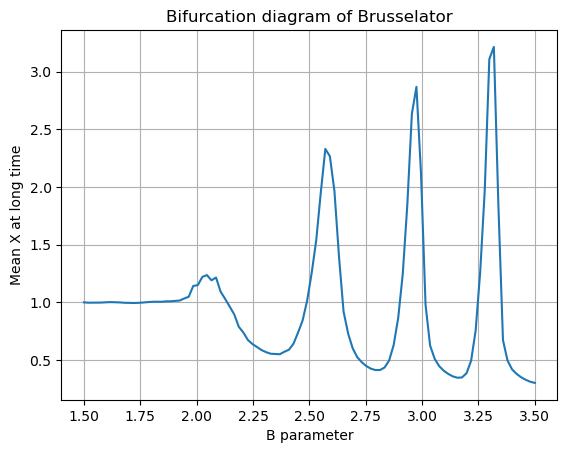

In [28]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class ThermoReactiveSystem:
    def __init__(self, A=1.0, B=3.0, X0=[1.0, 1.0], t_span=(0, 20), dt=0.01, noise_strength=0.0):
        self.A = A
        self.B = B
        self.X0 = np.array(X0)
        self.t_span = t_span
        self.dt = dt
        self.noise_strength = noise_strength
        self.times = np.arange(t_span[0], t_span[1], dt)

    def brusselator_deterministic(self, t, Y):
        X, Y_ = Y
        dX = self.A - (self.B + 1) * X + X**2 * Y_
        dY = self.B * X - X**2 * Y_
        return [dX, dY]

    def integrate_deterministic(self):
        sol = solve_ivp(self.brusselator_deterministic, self.t_span, self.X0, t_eval=self.times)
        return sol.t, sol.y

    def integrate_stochastic(self):
        """Euler-Maruyama method"""
        X = np.zeros((2, len(self.times)))
        X[:, 0] = self.X0
        sqrt_dt = np.sqrt(self.dt)
        for i in range(1, len(self.times)):
            x, y = X[:, i-1]
            dx = self.A - (self.B + 1) * x + x**2 * y
            dy = self.B * x - x**2 * y
            dW = np.random.randn(2) * self.noise_strength
            X[0, i] = x + dx * self.dt + dW[0] * sqrt_dt
            X[1, i] = y + dy * self.dt + dW[1] * sqrt_dt
        return self.times, X

    def plot_trajectory(self, stochastic=True):
        t, X = self.integrate_stochastic() if stochastic else self.integrate_deterministic()
        plt.plot(X[0], X[1], label='Trajectory')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Brusselator ({"stochastic" if stochastic else "deterministic"})')
        plt.grid(True)
        plt.show()

def bifurcation_diagram(A=1.0, B_vals=np.linspace(1.5, 3.5, 100), t_max=100):
    final_X = []
    for B in B_vals:
        system = ThermoReactiveSystem(A=A, B=B, t_span=(0, t_max), dt=0.01)
        t, X = system.integrate_deterministic()
        x_vals = X[0, -100:]  # last values to detect oscillation
        final_X.append(np.mean(x_vals))  # could also store min/max for oscillations
    plt.plot(B_vals, final_X)
    plt.xlabel('B parameter')
    plt.ylabel('Mean X at long time')
    plt.title('Bifurcation diagram of Brusselator')
    plt.grid(True)
    plt.show()

# Stochastic trajectory
sys = ThermoReactiveSystem(B=2.5, noise_strength=1)
sys.plot_trajectory(stochastic=True)

# Bifurcation
bifurcation_diagram()
